# Spatial transcriptomics functional analysis

Spatial transcriptomics technologies yield many molecular readouts that are hard to interpret by themselves. One way of summarizing this information is by inferring biological activities from prior knowledge.

In this notebook we showcase how to use `decoupler` for transcription factor and pathway activity inference from a human data-set. The data consists of a 10X Genomics Visium slide of a human lymph node and it is available at their [website](https://www.10xgenomics.com/resources/datasets).


<div class="alert alert-info">

**Note**
    
This tutorial assumes that you already know the basics of `decoupler`. Else, check out the [Usage](https://decoupler-py.readthedocs.io/en/latest/notebooks/usage.html) tutorial first.

</div>

## Loading packages

First, we need to load the relevant packages, `scanpy` to handle RNA-seq data
and `decoupler` to use statistical methods.

In [1]:
import scanpy as sc
import decoupler as dc

# Only needed for processing and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the data

We can download the data easily using `scanpy`:

In [2]:
adata = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata.var_names_make_unique()
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 4035 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

### QC, projection and clustering


Here we follow the standard pre-processing steps as described in the [scanpy vignette](https://scanpy-tutorials.readthedocs.io/en/latest/spatial/basic-analysis.html).
These steps carry out the selection and filtration of spots based on 
quality control metrics, the data normalization and scaling, and the detection of 
highly variable features.

<div class="alert alert-info">

**Note**
    
This is just an example, these steps should change depending on the data.

</div> 

In [3]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=10)

# Annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var_names.str.startswith('MT-')  
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Filter cells following standard QC criteria.
adata = adata[adata.obs.pct_counts_mt < 20, :]

# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Identify highly variable genes
sc.pp.highly_variable_genes(adata)

# Filter higly variable genes
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

# Scale the data
sc.pp.scale(adata, max_value=10)

/home/badi/miniconda3/envs/decoupler/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/badi/miniconda3/envs/decoupler/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Then we group spots based on the similarity of their transcription profiles. 
We can visualize the obtianed clusters on a UMAP or directly at the tissue:

/home/badi/miniconda3/envs/decoupler/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/home/badi/miniconda3/envs/decoupler/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome' as categorical


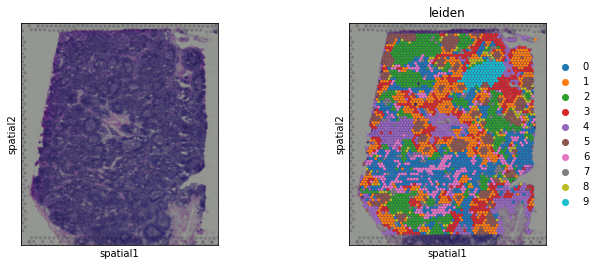

In [4]:
# Generate PCA features
sc.tl.pca(adata, svd_solver='arpack')

# Compute distances in the PCA space, and find spot neighbors
sc.pp.neighbors(adata)

# Run leiden clustering algorithm
sc.tl.leiden(adata)

# Visualize
sc.pl.spatial(adata, color=[None, 'leiden'], size=1.5, wspace=0)

## Transcription factor activity inference

The first functional analysis we can perform is to infer transcription factor (TF) activities from our transcriptomics data. We will need a gene regulatory network (GRN) and a statistical method.

### DoRothEA network

[DoRothEA](https://saezlab.github.io/dorothea/) is a comprehensive resource containing a curated collection of TFs and their transcriptional targets. Since these regulons were gathered from different types of evidence, interactions in DoRothEA are classified in different confidence levels, ranging from A (highest confidence) to D (lowest confidence). Moreover, each interaction is weighted by its confidence level and the sign of its mode of regulation (activation or inhibition).

For this example we will use the human version (mouse is also available) and we will use the confidence levels ABC. To access it we can use `decoupler`.

<div class="alert alert-info">

**Note**
    
In this tutorial we use the network DoRothEA, but we could use any other GRN coming from an inference method such as [CellOracle](https://morris-lab.github.io/CellOracle.documentation/), [pySCENIC](https://pyscenic.readthedocs.io/en/latest/) or [SCENIC+](https://scenicplus.readthedocs.io/en/latest/). 

</div> 

In [5]:
net = dc.get_dorothea(organism='human', levels=['A','B','C'])
net

,source,confidence,target,weight
0,ETS1,A,IL12B,1.000000
1,RELA,A,IL6,1.000000
2,MITF,A,BCL2A1,-1.000000
3,E2F1,A,TRERF1,1.000000
4,MITF,A,BCL2,1.000000
...,...,...,...,...
32272,IKZF1,C,PTK2B,0.333333
32273,IKZF1,C,PRKCB,0.333333
32274,IKZF1,C,PREX1,0.333333
32275,IRF4,C,SLAMF7,0.333333


### Activity inference with Multivariate Linear Model

To infer activities we will run the Multivariate Linear Model method (`mlm`). It models the observed gene expression by using a regulatory adjacency matrix (target genes x TFs) as covariates of a linear model. The values of this matrix are the associated interaction weights.
The obtained t-values of the fitted model are the activity scores.

To run `decoupler` methods, we need an input matrix (`mat`), an input prior knowledge
network/resource (`net`), and the name of the columns of `net` that we want to use.

In [6]:
dc.run_mlm(mat=adata, net=net, source='source', target='target', weight='weight', verbose=True)

Running mlm on mat with 4032 samples and 19813 targets for 294 sources.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.84s/it]


The obtained scores (t-values)(`mlm_estimate`) and p-values (`mlm_pvals`) are stored in the `.obsm` key:

In [7]:
adata.obsm['mlm_estimate']

,AHR,AR,ARID2,ARID3A,ARNT,ARNTL,ASCL1,ATF1,ATF2,ATF3,...,ZNF217,ZNF24,ZNF263,ZNF274,ZNF384,ZNF584,ZNF592,ZNF639,ZNF644,ZNF740
AAACAAGTATCTCCCA-1,0.531388,4.314746,2.580497,-2.264766,-0.211907,0.031246,-0.705776,-0.118562,0.799197,-0.045215,...,0.618186,-0.924915,-1.565854,-0.710968,1.119455,0.527442,0.561804,3.302261,-0.169674,1.063122
AAACAATCTACTAGCA-1,-0.684831,3.082588,2.525492,-0.760523,-0.134987,-1.309098,-0.090339,-0.262004,1.189955,-0.133106,...,0.001439,-1.933857,-1.526967,-0.431441,0.914302,0.337622,1.228477,3.548201,-0.341155,0.854290
AAACACCAATAACTGC-1,-0.966583,3.456383,0.965503,-2.124058,-0.092816,-1.105180,-0.122935,1.216181,1.331234,0.694221,...,1.274752,-1.129040,-1.979256,0.094362,1.624496,0.581281,-0.018216,2.823706,-0.299057,0.781646
AAACAGAGCGACTCCT-1,0.084335,3.552887,2.330085,-1.771000,-0.805615,-0.930001,-0.450489,0.392044,1.208560,-0.174565,...,0.172208,-1.423535,-1.436785,-1.608596,1.548968,0.492690,0.748371,2.668740,1.290589,0.898669
AAACAGCTTTCAGAAG-1,-0.113021,3.062887,1.692873,-1.376210,-0.237199,-1.540030,0.218669,0.059750,1.091377,-0.090121,...,0.990816,-1.068140,-1.429415,-0.121686,0.748879,0.354986,0.187215,2.666389,0.885567,0.440206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,-0.890853,3.760496,1.341087,-2.143296,0.199219,-1.063316,0.574174,-0.232284,-0.531052,-0.697277,...,2.323004,-1.538032,-2.160935,-0.829605,0.601897,-0.741982,0.184341,2.963787,-0.056685,0.354788
TTGTTTCATTAGTCTA-1,1.157550,3.614088,0.934339,-1.603928,-1.034015,-1.440529,-0.260510,-0.934655,0.368782,0.272667,...,1.935458,-1.350134,-1.803886,-1.309194,0.239783,0.030232,-0.161986,3.265780,0.185732,2.117301
TTGTTTCCATACAACT-1,-1.258395,2.891093,3.206188,-1.074143,-0.382113,-0.945535,-0.151498,1.225757,1.193222,-0.135125,...,1.379948,-0.543945,-1.674882,-0.879069,1.404226,0.835917,-0.477097,2.610413,-0.327709,1.427865
TTGTTTGTATTACACG-1,-0.739230,2.823546,3.534382,-1.066094,0.324376,-1.311501,-1.026220,0.729384,1.583481,0.750026,...,0.692039,-1.517446,-1.793239,-0.583169,1.176431,0.302630,-0.199994,2.923765,-1.083028,0.244638


**Note**: Each run of `run_mlm` overwrites what is inside of `mlm_estimate` and `mlm_pvals`. if you want to run `mlm` with other resources and still keep the activities inside the same `AnnData` object, you can store the results in any other key in `.obsm` with different names, for example:

In [8]:
adata.obsm['dorothea_mlm_estimate'] = adata.obsm['mlm_estimate'].copy()
adata.obsm['dorothea_mlm_pvals'] = adata.obsm['mlm_pvals'].copy()
adata

AnnData object with n_obs × n_vars = 4032 × 2491
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'leiden_colors'
    obsm: 'spatial', 'X_pca', 'mlm_estimate', 'mlm_pvals', 'dorothea_mlm_estimate', 'dorothea_mlm_pvals'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Visualization

To visualize the obtained scores, we can re-use many of `scanpy`'s plotting functions.
First though, we need to extract them from the `adata` object.

In [9]:
acts = dc.get_acts(adata, obsm_key='dorothea_mlm_estimate')
acts

AnnData object with n_obs × n_vars = 4032 × 294
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    uns: 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'leiden_colors'
    obsm: 'spatial', 'X_pca', 'mlm_estimate', 'mlm_pvals', 'dorothea_mlm_estimate', 'dorothea_mlm_pvals'

`dc.get_acts` returns a new `AnnData` object which holds the obtained activities in its `.X` attribute, allowing us to re-use many `scanpy` functions, for example:

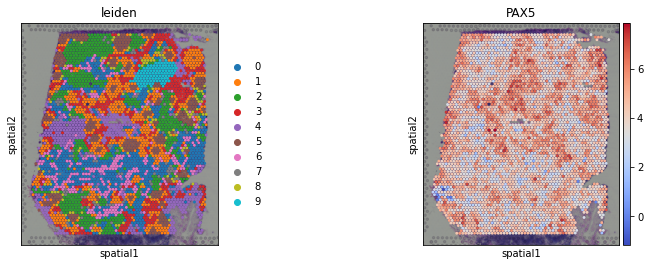

In [10]:
sc.pl.spatial(acts, color=['leiden', 'PAX5'], cmap='coolwarm', size=1.5, wspace=0)

Here we observe the activity infered for PAX5 across spots. Interestingly, PAX5 is a known TF crucial for B cell identity and function.
The inference of activities from "foot-prints" of target genes is more informative than just looking at the molecular readouts of a given TF, as an example here is the gene expression of PAX5, which is not very informative by itself:

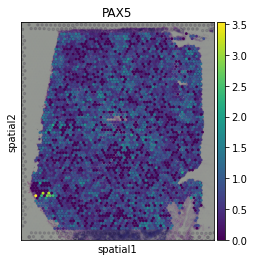

In [11]:
sc.pl.spatial(adata, color='PAX5', size=1.5)

### Exploration

With `decoupler` we can also see what is the mean activity per group (to show more TFs, increase the `min_std` parameter):

In [12]:
mean_acts = dc.summarize_acts(acts, groupby='leiden', min_std=0.4)
mean_acts

,ATF6,E2F4,ERG,ETS1,IRF1,IRF9,JUNB,MYC,PAX5,RBPJ,RFX5,STAT1,STAT2,STAT3,TBX21,TFDP1
0,5.425647,5.950534,0.976629,7.022013,-0.296379,0.364462,1.528090,13.706879,3.980209,-0.702463,11.314269,1.457677,3.198416,2.211520,1.840758,1.651450
1,3.962387,6.329461,0.899010,7.067654,-0.045027,0.298553,2.174330,14.132327,5.419888,0.276466,12.545614,1.347172,3.390375,1.564702,1.688480,1.655355
2,4.308863,6.204994,0.908421,7.663957,-0.114513,0.257776,1.688271,14.019668,3.838306,-0.979750,10.227130,1.548294,3.774739,1.867868,2.608472,1.564099
3,4.677002,6.115650,1.481284,7.245724,-0.132964,0.336158,1.832213,14.238405,4.562850,-0.398871,12.552104,1.873078,3.420067,2.550702,1.399548,1.762380
4,4.512222,5.423492,1.353292,6.270385,-0.105885,0.345371,1.903540,13.461339,4.112409,-0.179700,11.339410,1.291094,2.708822,2.374198,1.275249,1.746006
5,3.962252,9.133594,0.696790,6.748394,-0.343900,0.270207,2.835591,14.928737,5.408315,0.556190,12.102087,0.981099,2.347938,1.259365,1.193647,4.038791
6,5.333444,5.908932,1.525536,7.519007,-0.266074,0.298177,1.360018,14.022554,4.233101,-0.598897,12.145805,1.924856,3.262287,2.700020,1.615572,1.588291
7,4.924606,6.188310,1.961460,7.522125,-0.171967,0.355779,1.561548,14.214684,3.937887,-0.789719,11.407527,1.688864,3.329131,2.477357,1.921157,1.785569
8,4.742176,7.305005,0.868916,7.338912,-0.117163,0.395704,1.915956,14.851122,4.743230,-0.567329,11.423132,1.358365,3.459237,1.808232,1.838801,2.466387
9,4.523947,6.937476,0.825905,7.283448,1.095696,1.769770,1.874522,14.956728,4.442098,-0.750603,10.470515,2.704625,10.020187,1.340084,2.119819,2.382874


We can visualize which TF is more active across clusters using `seaborn`:

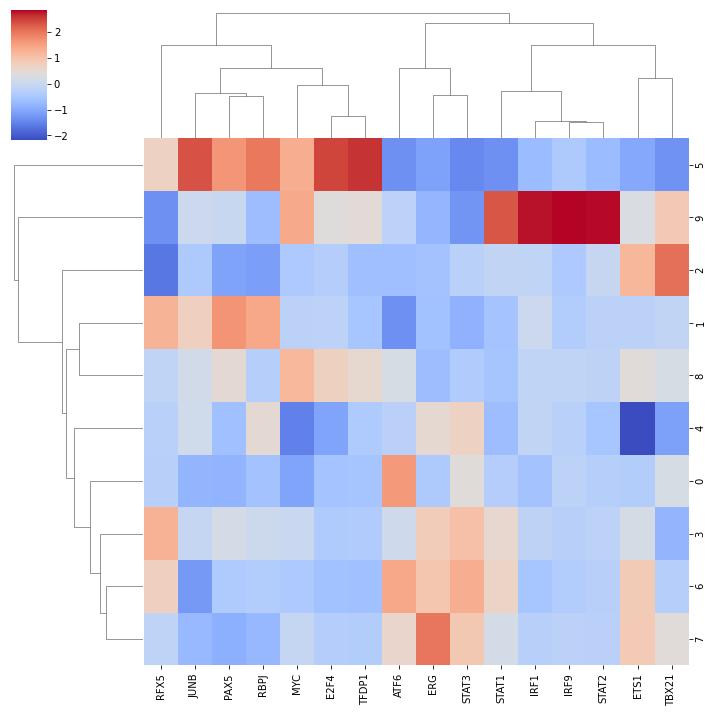

In [13]:
sns.clustermap(mean_acts, xticklabels=mean_acts.columns, cmap='coolwarm', z_score=1)
plt.show()

We can visualize again on the tissue some marker TFs:

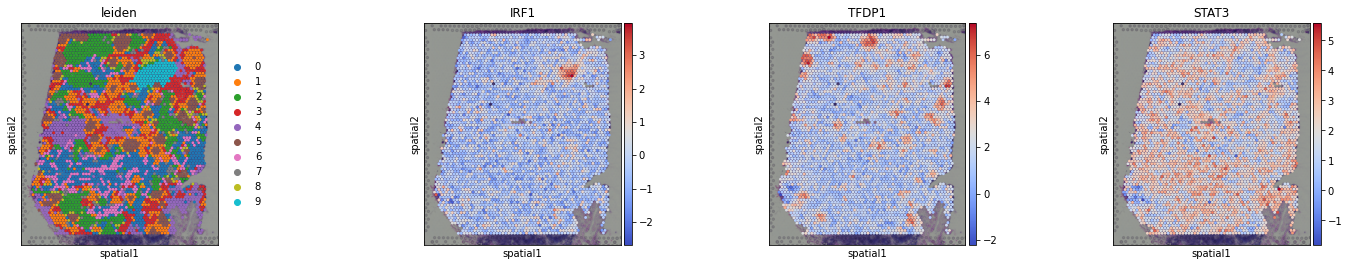

In [14]:
sc.pl.spatial(acts, color=['leiden', 'IRF1', 'TFDP1', 'STAT3'], cmap='coolwarm', size=1.5, wspace=0)

## Pathway activity inference

We can also infer pathway activities from our transcriptomics data.

### PROGENy model

[PROGENy](https://saezlab.github.io/progeny/) is a comprehensive resource containing a curated collection of pathways and their target genes, with weights for each interaction.
For this example we will use the human weights (mouse is also available) and we will use the top 100 responsive genes ranked by p-value. Here is a brief description of each pathway:
- **Androgen**: involved in the growth and development of the male reproductive organs.
- **EGFR**: regulates growth, survival, migration, apoptosis, proliferation, and differentiation in mammalian cells
- **Estrogen**: promotes the growth and development of the female reproductive organs.
- **Hypoxia**: promotes angiogenesis and metabolic reprogramming when O2 levels are low.
- **JAK-STAT**: involved in immunity, cell division, cell death, and tumor formation.
- **MAPK**: integrates external signals and promotes cell growth and proliferation.
- **NFkB**: regulates immune response, cytokine production and cell survival.
- **p53**: regulates cell cycle, apoptosis, DNA repair and tumor suppression.
- **PI3K**: promotes growth and proliferation.
- **TGFb**: involved in development, homeostasis, and repair of most tissues.
- **TNFa**: mediates haematopoiesis, immune surveillance, tumour regression and protection from infection.
- **Trail**: induces apoptosis.
- **VEGF**: mediates angiogenesis, vascular permeability, and cell migration.
- **WNT**: regulates organ morphogenesis during development and tissue repair.

To access it we can use `decoupler`.

In [15]:
model = dc.get_progeny(organism='human', top=100)
model

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40
...,...,...,...,...
1395,p53,CCDC150,-3.174527,7.396252e-13
1396,p53,LCE1A,6.154823,8.475458e-13
1397,p53,TREM2,4.101937,9.739648e-13
1398,p53,GDF9,3.355741,1.087433e-12


### Activity inference with Multivariate Linear Model
Like in the previous section, we will use `mlm` to infer activities:

In [16]:
dc.run_mlm(mat=adata, net=model, source='source', target='target', weight='weight', verbose=True)

# Store them in a different key
adata.obsm['progeny_mlm_estimate'] = adata.obsm['mlm_estimate'].copy()
adata.obsm['progeny_mlm_pvals'] = adata.obsm['mlm_pvals'].copy()

Running mlm on mat with 4032 samples and 19813 targets for 14 sources.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.79s/it]


The obtained scores (t-values)(`mlm_estimate`) and p-values (`mlm_pvals`) are stored in the `.obsm` key:

In [17]:
adata.obsm['progeny_mlm_estimate']

,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
AAACAAGTATCTCCCA-1,-0.188486,1.208809,0.845334,2.824020,2.956565,0.844544,-1.375955,-1.658008,-0.506245,3.400028,0.948775,0.354302,-0.394136,-0.592207
AAACAATCTACTAGCA-1,-0.296953,-0.593280,-0.558594,1.577488,3.994631,-0.434184,-0.145056,-2.026974,-1.356935,2.522995,0.198127,0.449313,-0.742038,0.015973
AAACACCAATAACTGC-1,-0.438746,0.179741,0.412451,1.812180,4.110078,0.803520,-1.396133,-2.972383,-1.486423,4.421825,0.567402,0.804890,-0.735639,0.174948
AAACAGAGCGACTCCT-1,0.007000,0.652227,-0.821658,2.101911,22.972557,-0.683112,-1.704974,-1.953475,-1.653204,3.975250,1.694650,0.755143,-0.501892,0.129601
AAACAGCTTTCAGAAG-1,-0.482217,0.393672,-0.576826,1.959044,4.177846,-0.527857,-0.996393,-3.752962,-1.633997,2.832229,0.967923,-0.093649,-0.575737,0.212081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,-0.292770,1.405961,0.330157,1.788581,4.066021,-0.854148,-1.628868,-2.403106,-1.488374,3.821350,0.888249,0.231786,-0.673330,-0.536630
TTGTTTCATTAGTCTA-1,0.216849,0.954299,-0.934332,2.779557,3.680631,0.638986,-0.052738,-1.530679,-1.766615,3.159299,-0.192867,0.422701,-0.358662,0.280121
TTGTTTCCATACAACT-1,-0.351691,0.822820,0.292143,1.386598,3.325152,0.149769,-0.320018,-2.387814,-0.621196,3.825063,0.242561,-0.025989,0.193019,0.199643
TTGTTTGTATTACACG-1,-1.506403,0.693628,-0.210152,2.470843,4.737563,-0.181501,-0.572574,-1.724866,-0.646039,2.713047,-0.016597,0.299411,-0.704308,-0.432493


### Visualization

Like in the previous section, we will extract the activities from the `adata` object.

In [18]:
acts = dc.get_acts(adata, obsm_key='progeny_mlm_estimate')
acts

AnnData object with n_obs × n_vars = 4032 × 14
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    uns: 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'leiden_colors'
    obsm: 'spatial', 'X_pca', 'mlm_estimate', 'mlm_pvals', 'dorothea_mlm_estimate', 'dorothea_mlm_pvals', 'progeny_mlm_estimate', 'progeny_mlm_pvals'

Once extracted we can visualize them:

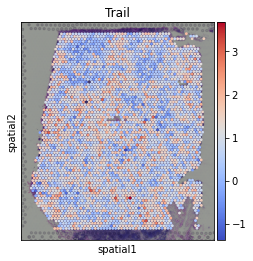

In [19]:
sc.pl.spatial(acts, color='Trail', cmap='coolwarm', size=1.5)

Here we show the activity of the pathway Trail, which is associated with apoptosis.

### Exploration

Let us see the mean pathway activity per cluster:

In [20]:
mean_acts = dc.summarize_acts(acts, groupby='leiden', min_std=0)
mean_acts

,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
0,-0.235733,0.390685,0.057316,2.028656,3.310778,-0.082057,-0.693550,-2.151323,-1.103416,2.876699,0.877714,0.212958,-0.744617,0.018514
1,-0.361732,0.395693,-0.508569,1.789956,3.559256,-0.339410,-0.866924,-2.090730,-1.236661,2.921738,1.268237,0.484229,-0.683389,-0.038626
2,-0.376320,0.267465,-0.413390,2.016582,3.970872,-0.114459,-0.707642,-2.385279,-1.294334,3.097718,0.508334,0.561026,-0.735835,0.041692
3,-0.247242,0.840521,-0.134884,2.248527,3.830161,-0.104251,-0.472488,-2.093627,-0.693436,3.823169,1.041569,0.493589,-0.611709,0.063977
4,-0.262289,0.643110,0.029117,1.830205,3.153491,-0.335399,-0.823879,-1.951632,-0.444595,3.039439,1.043293,0.136829,-0.619363,-0.133458
5,0.055557,0.533585,-0.446169,1.856608,2.214398,-0.528827,-1.073485,-1.667952,-1.513876,2.833984,1.222594,0.461531,-0.993194,-0.156339
6,-0.157354,0.582798,0.130340,2.260429,3.516362,0.081085,-0.560231,-2.286241,-0.858187,3.446463,0.952809,0.367802,-0.633847,0.089529
7,-0.203110,0.504909,0.016051,2.047894,3.947978,-0.105809,-0.891699,-2.283474,-0.394168,3.202955,0.720393,0.497918,-0.659265,0.014837
8,-0.186089,0.454411,-0.238047,2.045116,3.660860,-0.251945,-0.904483,-2.138275,-1.225798,2.962659,0.756347,0.422399,-0.794784,-0.045474
9,-0.292553,0.451394,-0.383922,2.077637,14.496776,-0.136514,-1.136826,-2.143701,-1.429141,3.352161,0.555814,0.549724,-0.665753,-0.115536


And visualize them:

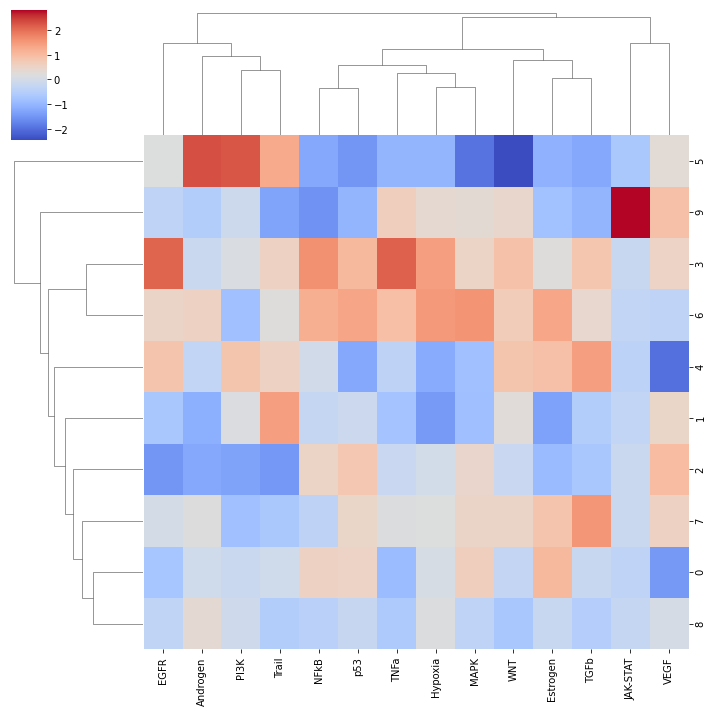

In [21]:
sns.clustermap(mean_acts, xticklabels=mean_acts.columns, cmap='coolwarm', z_score=1)
plt.show()

We can visualize again on the tissue some cluster-specific pathways:

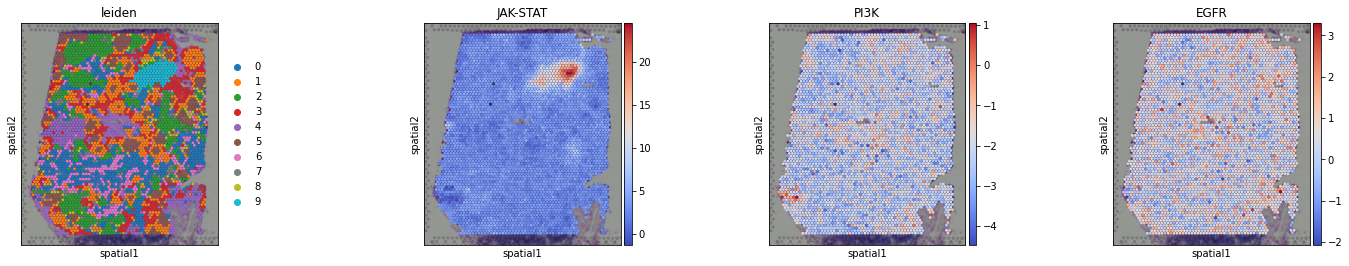

In [22]:
sc.pl.spatial(acts, color=['leiden', 'JAK-STAT', 'PI3K', 'EGFR'], cmap='coolwarm', size=1.5, wspace=0)

## Functional enrichment of biological terms

Finally, we can also infer activities for general biological terms or processes.

### MSigDB gene sets

The Molecular Signatures Database ([MSigDB](http://www.gsea-msigdb.org/gsea/msigdb/)) is a resource containing a collection of gene sets annotated to different biological processes.

In [23]:
msigdb = dc.get_resource('MSigDB')
msigdb

,genesymbol,collection,geneset
0,MSC,oncogenic_signatures,PKCA_DN.V1_DN
1,MSC,mirna_targets,MIR12123
2,MSC,chemical_and_genetic_perturbations,NIKOLSKY_BREAST_CANCER_8Q12_Q22_AMPLICON
3,MSC,immunologic_signatures,GSE32986_UNSTIM_VS_GMCSF_AND_CURDLAN_LOWDOSE_S...
4,MSC,chemical_and_genetic_perturbations,BENPORATH_PRC2_TARGETS
...,...,...,...
2407729,OR2W5P,immunologic_signatures,GSE22601_DOUBLE_NEGATIVE_VS_CD8_SINGLE_POSITIV...
2407730,OR2W5P,immunologic_signatures,KANNAN_BLOOD_2012_2013_TIV_AGE_65PLS_REVACCINA...
2407731,OR52L2P,immunologic_signatures,GSE22342_CD11C_HIGH_VS_LOW_DECIDUAL_MACROPHAGE...
2407732,CSNK2A3,immunologic_signatures,OCONNOR_PBMC_MENVEO_ACWYVAX_AGE_30_70YO_7DY_AF...


As an example, we will use the hallmark gene sets, but we could have used any other. 

<div class="alert alert-info">

**Note**
    
To see what other collections are available in MSigDB, type: `msigdb['collection'].unique()`.

</div>  

We can filter by for `hallmark`:

In [24]:
# Filter by hallmark
msigdb = msigdb[msigdb['collection']=='hallmark']

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]

# Rename
msigdb.loc[:, 'geneset'] = [name.split('HALLMARK_')[1] for name in msigdb['geneset']]

msigdb

,genesymbol,collection,geneset
11,MSC,hallmark,TNFA_SIGNALING_VIA_NFKB
149,ICOSLG,hallmark,TNFA_SIGNALING_VIA_NFKB
223,ICOSLG,hallmark,INFLAMMATORY_RESPONSE
270,ICOSLG,hallmark,ALLOGRAFT_REJECTION
398,FOSL2,hallmark,HYPOXIA
...,...,...,...
878342,FOXO1,hallmark,PANCREAS_BETA_CELLS
878418,GCG,hallmark,PANCREAS_BETA_CELLS
878512,PDX1,hallmark,PANCREAS_BETA_CELLS
878605,INS,hallmark,PANCREAS_BETA_CELLS


### Activity inference with Multivariate Linear Model
Like in the previous section, we will use `mlm` to infer activities:

In [25]:
dc.run_mlm(mat=adata, net=msigdb, source='geneset', target='genesymbol', weight=None, verbose=True)

# Store them in a different key
adata.obsm['msigdb_mlm_estimate'] = adata.obsm['mlm_estimate'].copy()
adata.obsm['msigdb_mlm_pvals'] = adata.obsm['mlm_pvals'].copy()

Running mlm on mat with 4032 samples and 19813 targets for 50 sources.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.03s/it]


The obtained scores (t-values)(`mlm_estimate`) and p-values (`mlm_pvals`) are stored in the `.obsm` key:

In [26]:
adata.obsm['msigdb_mlm_estimate'].iloc[:, 0:5]

,ADIPOGENESIS,ALLOGRAFT_REJECTION,ANDROGEN_RESPONSE,ANGIOGENESIS,APICAL_JUNCTION
AAACAAGTATCTCCCA-1,3.582305,11.334203,4.234747,0.137435,3.802077
AAACAATCTACTAGCA-1,2.671094,12.194424,2.753398,-0.224686,2.211782
AAACACCAATAACTGC-1,3.254313,11.859533,4.187515,-0.349350,3.922884
AAACAGAGCGACTCCT-1,1.460420,11.618388,4.099222,-0.313021,4.280679
AAACAGCTTTCAGAAG-1,1.603691,12.120145,2.952333,-0.271135,2.790807
...,...,...,...,...,...
TTGTTTCACATCCAGG-1,2.417024,9.619124,4.501319,0.699741,3.429903
TTGTTTCATTAGTCTA-1,3.775330,11.446894,4.151324,0.583313,5.161738
TTGTTTCCATACAACT-1,2.932805,12.189088,3.406567,-0.550669,4.736694
TTGTTTGTATTACACG-1,1.151807,10.742589,2.760084,-0.723917,3.925781


### Visualization

Like in the previous sections, we will extract the activities from the `adata` object.

In [27]:
acts = dc.get_acts(adata, obsm_key='msigdb_mlm_estimate')
acts

AnnData object with n_obs × n_vars = 4032 × 50
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    uns: 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'leiden_colors'
    obsm: 'spatial', 'X_pca', 'mlm_estimate', 'mlm_pvals', 'dorothea_mlm_estimate', 'dorothea_mlm_pvals', 'progeny_mlm_estimate', 'progeny_mlm_pvals', 'msigdb_mlm_estimate', 'msigdb_mlm_pvals'

Once extracted we can visualize them:

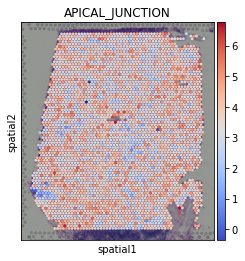

In [28]:
sc.pl.spatial(acts, color='APICAL_JUNCTION', cmap='coolwarm', size=1.5)

### Exploration

Let us see the most variable terms:

In [29]:
mean_acts = dc.summarize_acts(acts, groupby='leiden', min_std=0.35)
mean_acts

,COAGULATION,DNA_REPAIR,E2F_TARGETS,EPITHELIAL_MESENCHYMAL_TRANSITION,G2M_CHECKPOINT,INTERFERON_ALPHA_RESPONSE,INTERFERON_GAMMA_RESPONSE,KRAS_SIGNALING_UP,MYC_TARGETS_V1,OXIDATIVE_PHOSPHORYLATION,TNFA_SIGNALING_VIA_NFKB,UNFOLDED_PROTEIN_RESPONSE
0,0.952400,3.288563,1.090645,1.618884,2.080138,3.904741,5.837221,1.469192,18.919279,10.948023,3.336524,6.792207
1,0.507895,3.667026,1.263194,0.769735,2.176249,4.147588,5.594840,1.383072,19.796711,11.067318,2.634282,5.720784
2,0.713078,3.559376,0.962561,1.215796,1.934632,4.388570,5.846885,1.429250,19.889725,11.445617,3.115541,6.276733
3,1.784987,3.652838,0.858465,2.945634,1.832419,4.097078,6.311147,2.180722,20.106998,11.705830,4.497266,6.225229
4,1.605946,3.044741,0.842482,2.983389,1.584821,3.771497,5.217919,1.660632,18.754562,10.439170,3.145799,5.770047
5,0.669163,4.479780,5.285630,0.682815,4.448758,3.479510,4.705666,1.515177,21.911728,13.188506,1.886962,5.720539
6,1.797583,3.589422,0.699074,2.483427,1.931533,3.930642,6.288488,2.142133,19.284714,11.306396,4.472759,6.775112
7,1.766313,3.687238,0.970407,2.642560,2.070699,4.431295,6.062190,2.108777,19.949854,11.676679,3.498453,6.584166
8,0.750419,3.982705,2.575233,1.394051,2.954589,4.300572,5.852424,1.354083,21.482012,12.530923,3.024118,6.544428
9,0.693047,4.042583,2.055638,0.901221,2.784884,9.241279,9.130281,1.200511,21.893719,12.714638,2.457613,6.549897


And visualize them:

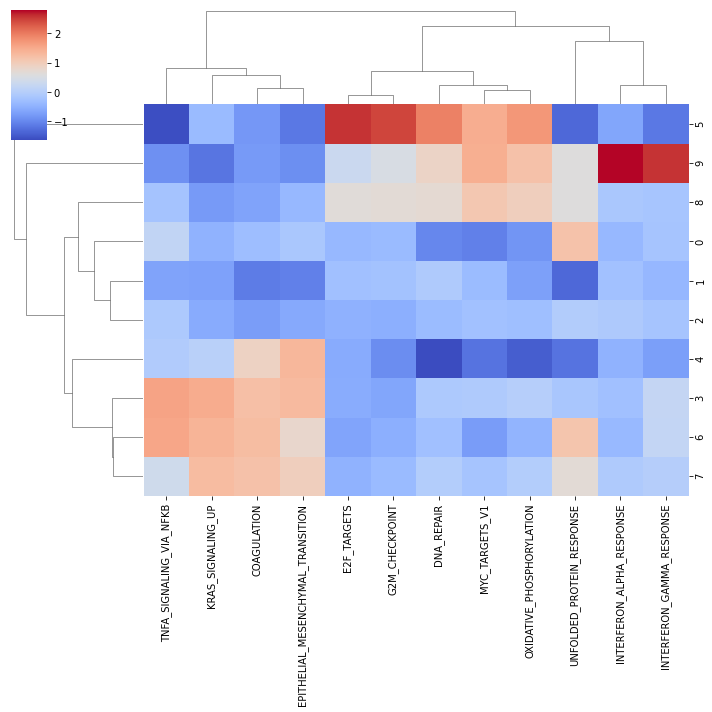

In [30]:
sns.clustermap(mean_acts, xticklabels=mean_acts.columns, cmap='coolwarm', z_score=1)
plt.show()

We can visualize again on the tissue some cluster-specific terms:

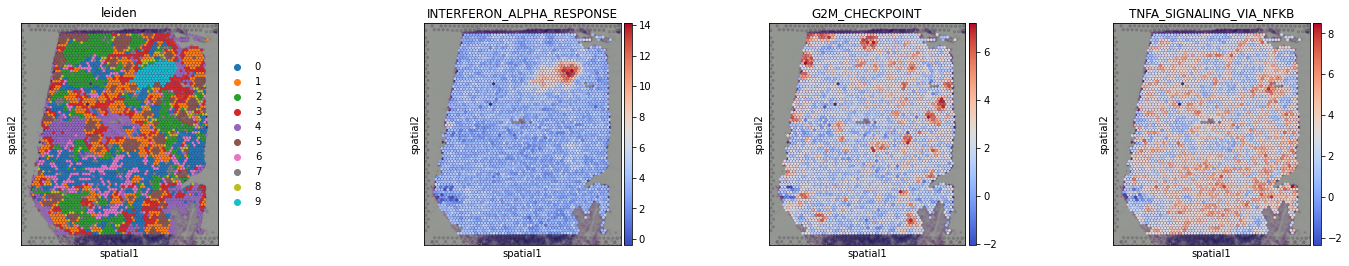

In [31]:
sc.pl.spatial(acts, color=['leiden', 'INTERFERON_ALPHA_RESPONSE', 'G2M_CHECKPOINT', 'TNFA_SIGNALING_VIA_NFKB'], cmap='coolwarm', size=1.5, wspace=0)